# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

# для проверки данных на нормальность
from scipy.stats import shapiro 
from scipy.stats import normaltest

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

import plotly
import plotly.express as px

Итак, прочитаем нашу таблицу:

In [2]:
churn_data = pd.read_csv('data/churn.zip')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

In [3]:
churn_data['string_exited'] = churn_data['Exited'].apply(lambda x : 'Ушедший' if x==1 else 'Лояльный') 

In [4]:
fig = px.pie(churn_data, names='string_exited', title='Соотношение ушедших и лояльных клиентов')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [5]:
fig = px.histogram(
    churn_data, 
    x='Balance', 
    #log_y=True,
    color='string_exited',
    title='Распределение баланса клиента в разрезе признака оттока')
fig.show()

In [6]:
# убираем строковый признак, больше он нам не нужен
churn_data.drop('string_exited', axis=1, inplace=True)
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [7]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [8]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [9]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [10]:
churn_data[churn_data.duplicated()].sum()

CreditScore        0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [11]:
# создаём новые признаки
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

# кодируем категориальный
churn_data['Gender_code'] = churn_data['Gender'].apply(lambda x: 1 if x.lower() == 'male' else 0)
churn_data.drop('Gender', axis=1, inplace=True)

# выводим статистические характеристики
churn_data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_code
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487,0.524512
std,98.168937,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558,0.499498
min,350.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676,0.000000
25%,584.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275,0.000000
50%,651.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143,1.000000
75%,722.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941,1.000000
max,850.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889,1.000000


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [12]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [13]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [15]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


0    0.675704
1    0.324296
Name: Exited, dtype: float64



Test :


0    0.675159
1    0.324841
Name: Exited, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

Один из новых признаков, BalanceSalaryRatio, имеет большой выброс. Можно предварительно обработать входящие данные, удалив строки с выбросами, либо попробовать работать с такими данными. Опробуем оба варианта.

Для начала объявим несколько полезных функций:
* проверка каждого признака на нормальное распределение
* скалирование DateFrame с определённым набором признаков
* визуализация DataFrame

In [16]:
def is_df_normilized(input_df, alpha=0.05):
    """ Checks each feature for a normal distribution on 2 tests. 
    Returns a table in which True is specified for the normal distribution """
    normalized_columns = ['attribute','data_shapiro','data_normaltest']
    normalized_list = []
    for col in input_df.columns:
        _, p_shap = shapiro(input_df[col])
        data_shap = p_shap > alpha
        _, p_norm = normaltest(input_df[col])
        data_norm = p_norm > alpha/2
        normalized_list.append([col, data_shap, data_norm])
    return pd.DataFrame(normalized_list, columns=normalized_columns)

In [17]:
def scale_without_features(data, scaler, columns_not_to_scale=[], is_scaler_trained=False):
    """ returns a scaled copy of the dataframe without specified features """
    data_copy = data.copy()
    columns_to_scale = list(set(data.columns) - set(columns_not_to_scale))
    data_to_scale = data_copy[columns_to_scale]
    if is_scaler_trained:
        data_copy[columns_to_scale] = scaler.transform(data_to_scale)
    else:
        data_copy[columns_to_scale] = scaler.fit_transform(data_to_scale)
    return data_copy

In [18]:
def attr_distribution_visualization(input_df, columns_to_visual=None, title='Распределение атрибутов'):
    """ sets the parameters of the canvas, the title and visualize the distribution curves """
    if columns_to_visual is None:
        columns_to_visual = input_df.columns
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8))
    ax1.set_title(title)
    for col in columns_to_visual:
        sns.kdeplot(input_df[col], ax=ax1, label=col)
    sns.boxplot(data=input_df[columns_to_visual], ax=ax2, orient='h')
    ax1.legend()

Теперь начнём применять наши функции к тестовым данным.
Наша цель:
1. Понять, как распределены данные, нормально или нет
2. В зависимости от распределения применить:
* Если прзнак распределён ненормально, его необходимо нормализовать
* Если признак распределён нормально, его необходимо стандартизировать
* Если разброс значений небольшой, то можно обойтись без преобразований
3. Если данные необходимо нормализовать, то можем воспользоваться следующими алгоритмами:
* если данные очищены от выбросов, то используем MinMaxScaler
* если данные не очищены от выбросов, то используем RobustScaler
4. Если данные необходимо стандартизировать, то можем воспользоваться следующим алгоритмом:
* StandardScaler – преобразует данные таким образом, чтобы среднее значений равнялось 0, а стандартное отклонение — 1. 

In [19]:
# оцениваем распределение данных
display(is_df_normilized(X_train))

,attribute,data_shapiro,data_normaltest
0,CreditScore,False,False
1,Age,False,False
2,Tenure,False,False
3,Balance,False,True
4,NumOfProducts,False,False
5,HasCrCard,False,False
6,IsActiveMember,False,False
7,EstimatedSalary,False,False
8,BalanceSalaryRatio,False,False
9,TenureByAge,False,False


In [20]:
display(is_df_normilized(X_test))

,attribute,data_shapiro,data_normaltest
0,CreditScore,False,False
1,Age,False,False
2,Tenure,False,False
3,Balance,True,True
4,NumOfProducts,False,False
5,HasCrCard,False,False
6,IsActiveMember,False,False
7,EstimatedSalary,False,False
8,BalanceSalaryRatio,False,False
9,TenureByAge,False,False


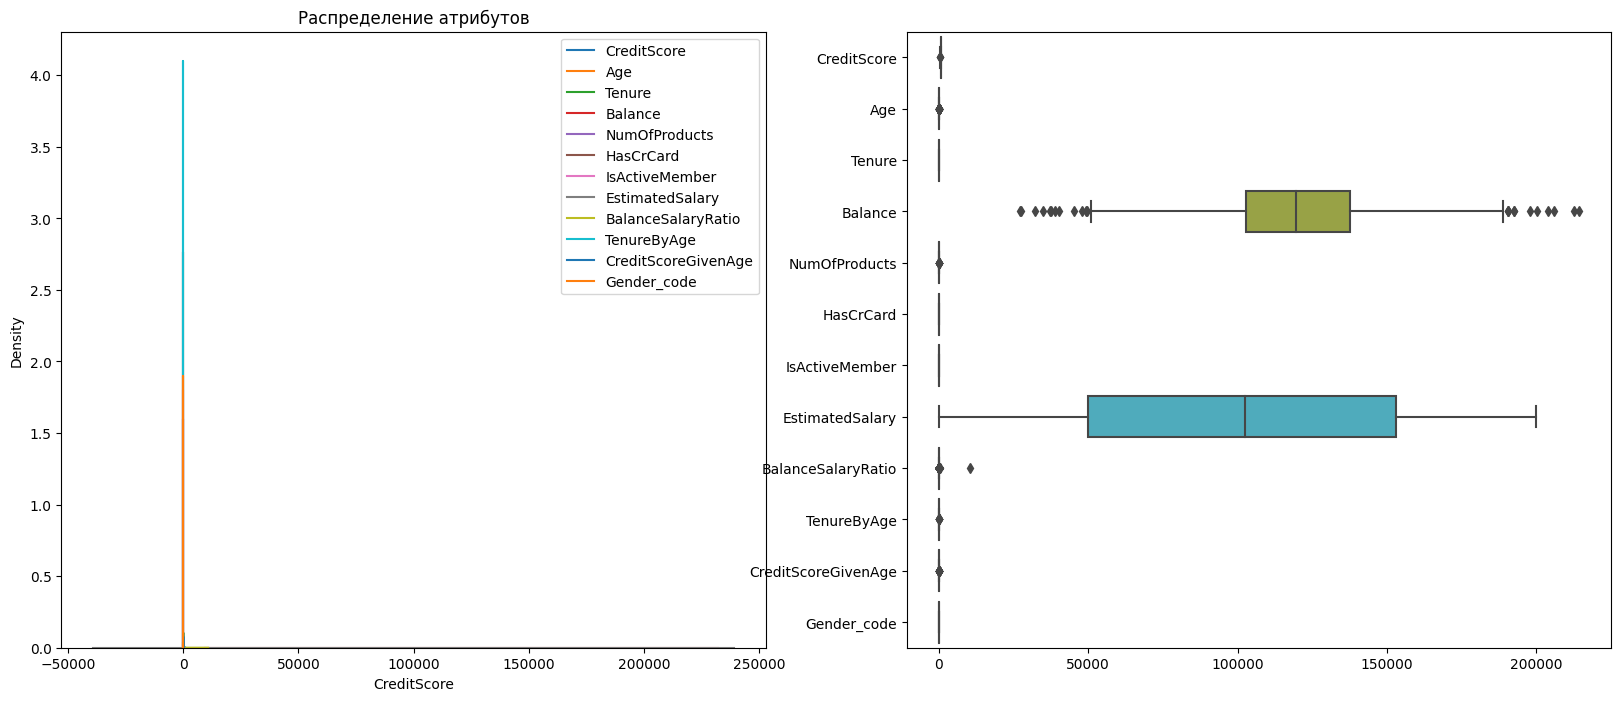

In [21]:
# также визуально оцениваем данные на распределение и наличие выбросов
attr_distribution_visualization(X_train)

**Выводы:** 
* Все признаки, кроме Balance, не распределены нормально
* У нас в данных есть три бинарных признака: 'HasCrCard', 'IsActiveMember','Gender_code'
* У нас есть категориальный признак: 'NumOfProducts'
* В некоторых признаках присутствуют выбросы

Следовательно, нам следует произвести следующие преобразования:
1. Balance стандартизировать
2. Бинарные признаки не трогать
3. Остальные признаки нормализовать методом RobutScaler

In [22]:
# масштабируем Balance
s_scaler = preprocessing.StandardScaler()
columns_without_balance = list(set(X_train.columns) - set(['Balance'])) # to reuse the distribution function
X_train = scale_without_features(X_train, s_scaler, columns_without_balance)
X_test = scale_without_features(X_test, s_scaler, columns_without_balance)

In [23]:
# нормализуем все признаки, кроме Balance, категориальных и бинарных признаков
# на тренировочной выборке обучаем скейлер, на тестовой только преобразуем признаки, используя обученный скейлер
binary_features_and_balance = ['HasCrCard', 'NumOfProducts', 'IsActiveMember','Gender_code', 'Balance']
r_scaler = preprocessing.RobustScaler()
X_train = scale_without_features(X_train, r_scaler, binary_features_and_balance, is_scaler_trained=False)
X_test = scale_without_features(X_test, r_scaler, binary_features_and_balance, is_scaler_trained=True)

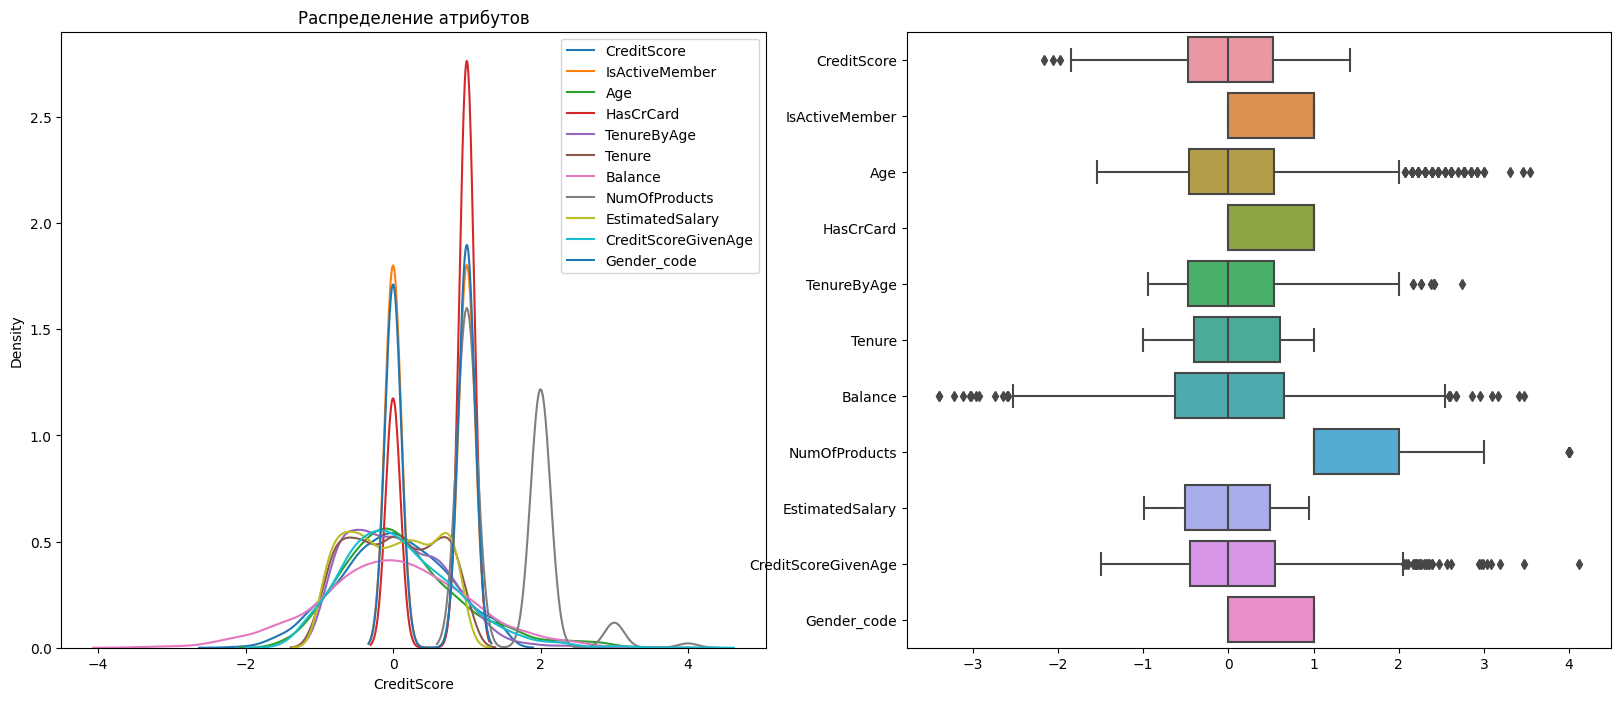

In [24]:
# визуализируем полученные данные
# в BalanceSalaryRatio слишком большой выброс, который мешает визуализаци. Исключим этот признак
cols = list(set(X_train.columns) - set(['BalanceSalaryRatio']))
attr_distribution_visualization(X_train, columns_to_visual=cols)

In [25]:
# заготовка на определение выбросов для их последующего удаления
def hampel(vals_orig):
    vals = vals_orig.copy()    
    # print(vals.shape)
    difference = np.abs(vals.median()-vals)
    median_abs_deviation = difference.median()
    threshold = 10 * median_abs_deviation
    outlier_idx = difference > threshold
    # print(outlier_idx)
    # return vals[outlier_idx]
    vals[outlier_idx] = np.nan
    return(vals)

# test = X_train[['BalanceSalaryRatio']]
# test_result = hampel(test).dropna()
# display(test.shape, test_result.shape)
# display(test.max())
# display(test_result.max())

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> Укажите название метрики и обоснования своего выбора здесь

Выбираем F1-меру, так как нам важно найти баланс между ложноположительными и ложноотрицательными срабатываниями модели.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Ваши рассуждения и ответ — *здесь*.

Рассмотрим все четыре метрики, которые мы проходили в курсе.

**ACCURACY:** доля правильных ответов среди всех ответов модели. 
Применяется для сбалансированных классов, то есть нам не подходит

**PRECISION:** cпособность модели отделять класс 1 от класса 0.
Используется, если важно определить минимальное количество ложноположительных срабатываний. В нашем случае высокие показатели этой метрики означали бы, что мы минимизируем количество звонков колл-центра.

**RECALL:** Способность модели находить класс 1.
Используется, если важно найти как можно больше правильных ответов. Другими словами, уменьшить количество ложноотрицательных срабатываний. В нашем случае высокие показатели этой метрики означали бы возможность сохранить как можно больше клиентов.

**F1-мера:** баланс между метриками precision и recall.
В нашем случае означает баланс между сохранением ресурсов колл-центра и возможность сохранить как можно больше клиентов. Выбираем эту метрику, как целевую.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [26]:
# объявим функцию по обучению модели
def train_model(model, train_X, train_y, test_X, test_y, title=''):
    
    # объявим функцию для расчёта и отображения целевой метрики F1
    def calc_and_print_f1_score(y, y_pred, title_in=''):
        nonlocal title
        print(title_in, title ,'F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred)))

    # обучаем модель
    model.fit(X=train_X, y=train_y)

    # предсказываем класс на тренировочной и тестовой выборках
    train_y_pred = model.predict(train_X)
    test_y_pred = model.predict(test_X)
    
    # рассчитываем целевую метрику F1
    calc_and_print_f1_score(train_y, train_y_pred, title_in='TRAIN')
    calc_and_print_f1_score(test_y, test_y_pred, title_in='TEST')
    
    return model

In [28]:
# обучаем модель линейной регрессии
log_reg = linear_model.LogisticRegression(random_state=42, max_iter=10000)
log_reg = train_model(log_reg, X_train, y_train, X_test, y_test, title='lbfgs')

TRAIN lbfgs F1 score: 0.51
TEST lbfgs F1 score: 0.50


In [29]:
# поиграемся с параметрами модели
log_reg_param = linear_model.LogisticRegression(random_state=42, solver='liblinear', penalty='l1')
log_reg_param = train_model(log_reg_param, X_train, y_train, X_test, y_test)

TRAIN  F1 score: 0.51
TEST  F1 score: 0.49


In [30]:
# поиграемся с параметрами модели
log_reg_param = linear_model.LogisticRegression(random_state=42, solver='newton-cholesky')
log_reg_param = train_model(log_reg_param, X_train, y_train, X_test, y_test, title='newton-cholesky')

TRAIN newton-cholesky F1 score: 0.51
TEST newton-cholesky F1 score: 0.50


> Ваши выводы и рассуждения — *здесь*.

Использование модели линейной регрессии дало требуемыq результат по минимальной планке: метрика F1 достигла целевого показателя в 0.5.
Но что странно, ранее эта же модель показывала метрику в 0.3-0.4. Повторить эти результаты не удалось.

Изменение параметров модели линейной регрессии не дало больших изменений. Метод оптимизации функции ‘newton-cg’ при методе регуляризации 'l1' и методы оптимизации 'newton-cg' или 'newton-cholesky' позволили достигнуть значения метрики в 0.49 на тестовой выборке. Это почти целевое значение, но всё ещё не подходит нам. При этом изменение коэффициента C либо не меняло метрику, либо снижало её.

**Вывод:** полученная модель является недообученной, то есть не позволяет с достаточной уверенностью определять истинный класс прогнозируемого признака. Достаточность определяется показателем выбранной метрики F1.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [31]:
# Генерируем полиномиальные признаки третьей степени для тренировочной и тестовой выборок. 
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# сравниваем размеры выборок
print(f'X_train shape = {X_train.shape}')
print(f'X_train_poly shape = {X_train_poly.shape}')

X_train shape = (1881, 12)
X_train_poly shape = (1881, 454)


In [35]:
# обучаем модель линейной регрессии на полиномиальных признаках
log_reg_poly = linear_model.LogisticRegression(random_state=42, max_iter=10000)
log_reg_poly = train_model(log_reg_poly, X_train_poly, y_train, X_test_poly, y_test, title='poly lbfgs')

TRAIN poly lbfgs F1 score: 0.41
TEST poly lbfgs F1 score: 0.40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [36]:
# обучаем модель линейной регрессии на полиномиальных признаках
# при этом изменим параметры модели
log_reg_poly_liblinear = linear_model.LogisticRegression(random_state=42, solver='liblinear', penalty='l1', max_iter=10000, C=10000)
log_reg_poly_liblinear = train_model(log_reg_poly_liblinear, X_train_poly, y_train, X_test_poly, y_test, title='poly liblinear')

TRAIN poly liblinear F1 score: 0.77
TEST poly liblinear F1 score: 0.62


> Ваши выводы и рассуждения — *здесь*

Использование полиномиальных признаков существенно улучшает модель, но при этом ощутимо увеличивает время обучения модели, т.к. количество признаков возрасло на порядок: с 12 до 454.

При правильном подборе параметров модели удалось повысить F1-метрику на тестовой выборке до 0.62, что уже выше целевого показателя.

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [38]:
# реализуем функцию расчёта и визуализации метрик при разных порогах вероятности
def thresholds_metrics(y, y_proba_pred, title=''):
    # Инициализируем список, куда будем сохранять метрики.
    recall_scores = []
    precision_scores = []
    f1_scores = dict()
    # Задаём значения порогов вероятности
    thresholds = np.arange(0.1, 1, 0.05)
    # В цикле перебираем значения порогов вероятности
    for threshold in thresholds:
        # Делаем предсказание
        y_pred = y_proba_pred.apply(lambda x: 1 if x > threshold else 0)
        #Считаем метрики и добавляем их в списки
        recall_scores.append(metrics.recall_score(y, y_pred))
        precision_scores.append(metrics.precision_score(y, y_pred, zero_division=1))
        f1_scores[threshold] = metrics.f1_score(y, y_pred)
    
    #Визуализируем метрики при различных threshold
    fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
    #Строим линейный график зависимости recall от threshold
    ax.plot(thresholds, recall_scores, label='Recall')
    #Строим линейный график зависимости precision от threshold
    ax.plot(thresholds, precision_scores, label='Precision')
    #Строим линейный график зависимости F1 от threshold
    ax.plot(thresholds, f1_scores.values(), label='F1-score')

    #Даём названия графику и осям
    ax.set_title(title + ' – recall/precision/F1 dependence on the threshold')
    ax.set_xlabel('Probability threshold')
    ax.set_ylabel('Score')
    #Устанавливаем отметки по оси x
    ax.set_xticks(thresholds) 
    #Отображаем легенду
    ax.legend()
    
    return f1_scores
    

Расчитаем метрики для модели **log_reg_poly**:

max F1-score is 0.49 in threshold = 0.45


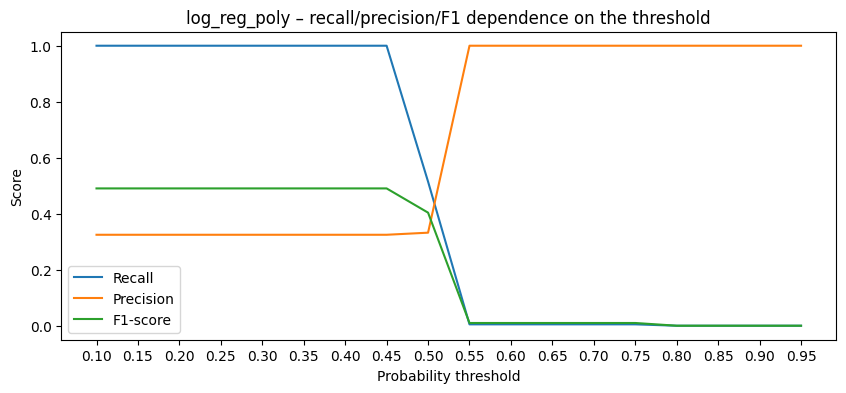

In [39]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(log_reg_poly.predict_proba(X_test_poly)[:, 1])
log_reg_poly_f1 = thresholds_metrics(y_test, y_test_proba_pred, title='log_reg_poly')

threshold_poly_opt = max(sorted(log_reg_poly_f1, reverse=True), key=log_reg_poly_f1.get)
print('max F1-score is {:.2f} in threshold = {:.2f}'.format(
    max(sorted(log_reg_poly_f1.values(), reverse=True)),
    threshold_poly_opt
))

In [40]:
# вручную определяем все предсказания модели log_reg_poly согласно оптимальному порогу вероятности
# TRAIN
y_train_proba_pred = pd.Series(log_reg_poly.predict_proba(X_train_poly)[:, 1])
y_train_proba_pred_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_poly_opt else 0)
print('TRAIN: F1-score in optimal treshold = {:.2f}'.format(metrics.f1_score(y_train, y_train_proba_pred_opt)))

# TEST
y_test_proba_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_poly_opt else 0)
print('TEST: F1-score in optimal treshold = {:.2f}'.format(metrics.f1_score(y_test, y_test_proba_pred_opt)))

TRAIN: F1-score in optimal treshold = 0.49
TEST: F1-score in optimal treshold = 0.49


Расчитаем метрики для модели **log_reg_poly_liblinear**:

max F1-score is 0.64 in threshold = 0.30


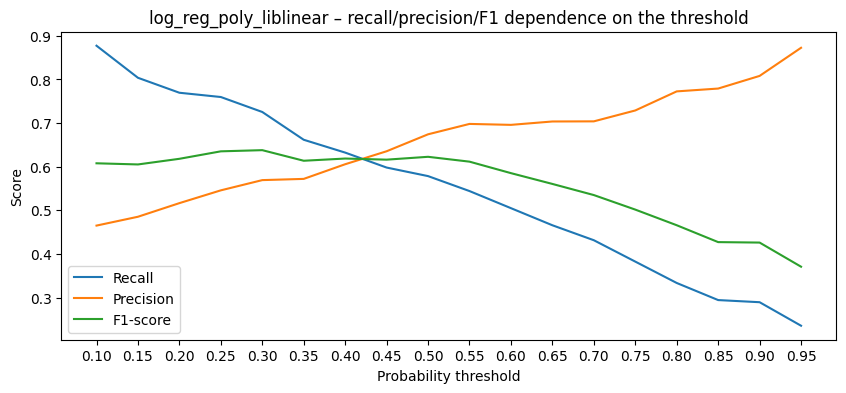

In [41]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_liblinear_proba_pred = pd.Series(log_reg_poly_liblinear.predict_proba(X_test_poly)[:, 1])
log_reg_poly_liblinear_f1 = thresholds_metrics(y_test, y_test_liblinear_proba_pred, title='log_reg_poly_liblinear')

threshold_poly_liblinear_opt = max(log_reg_poly_liblinear_f1, key=log_reg_poly_liblinear_f1.get)
print('max F1-score is {:.2f} in threshold = {:.2f}'.format(
    max(log_reg_poly_liblinear_f1.values()),
    threshold_poly_liblinear_opt
))

In [42]:
# вручную определяем все предсказания модели log_reg_poly_liblinear согласно оптимальному порогу вероятности
# TRAIN
y_train_liblinear_proba_pred = pd.Series(log_reg_poly_liblinear.predict_proba(X_train_poly)[:, 1])
y_train_liblinear_proba_pred_opt = y_train_liblinear_proba_pred.apply(lambda x: 1 if x > threshold_poly_liblinear_opt else 0)
print('TRAIN: F1-score in optimal treshold = {:.2f}'.format(metrics.f1_score(y_train, y_train_liblinear_proba_pred_opt)))

# TEST
y_test_liblinear_proba_pred_opt = y_test_liblinear_proba_pred.apply(lambda x: 1 if x > threshold_poly_liblinear_opt else 0)
print('TEST: F1-score in optimal treshold = {:.2f}'.format(metrics.f1_score(y_test, y_test_liblinear_proba_pred_opt)))


TRAIN: F1-score in optimal treshold = 0.77
TEST: F1-score in optimal treshold = 0.64


**Выводы:** рассмотрим изменение метрик для обоих наших моделей: lbfgs и liblinear.

**lbfgs**:
* модель с использованием обычных признаков показала результат метрики F1 в **0.5** на тестовой выборке. При этом первоначально она показывала результат в **0.3-0.4**, но воспроизвести это не удалось. (Я полагаю, что результаты где-то закешировались, но пока разбираюсь)
* при использовании полиномиальных признаков показатели метрики равны **0.4**
* при подборе оптимального порога вероятности показатель вырос до 0.49

**liblinear:**
* первоначально были получены показатели метрики в **0.5**
* использование полиномиальных признаков подняло показатель до **0.62**
* подбор оптимального порога вероятности ещё немного увеличил метрику. до **0.64**

Итого можно сделать вывод, что целевой показатель метрики достигнут, но показатели метрики всё ещё не особо высокие и есть куда расти. 
Подбор разных параметров модели, работа с признаками и подбор оптимального порога вероятности ощутимо повышают результативность модели и этому необходимо уделять внимание.

Также любопытно посмотреть, можно ли достичь лучших показателей с помощью дереывьев решений. Переходим к следующему модулю.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [38]:
# X_train, X_test, y_train, y_test = model_selection.train_test_split(
#     X, y, 
#     stratify=y, 
#     random_state=0
# )
# print('Train shape: {}'.format(X_train.shape))
# print('Test shape: {}'.format(X_test.shape))

Импортируем необходимые для выполнения практики модули:

In [39]:
# from sklearn import tree
# from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [40]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [41]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [42]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

In [43]:
# Ваш код здесь

> Ваши выводы и рассуждения — *здесь*

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [44]:
# Ваш код здесь